# Libraries

In [1]:
import re
import io
import ipywidgets as widgets
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
from sklearn.feature_extraction import DictVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import ConfusionMatrixDisplay

# Data Loading

The data is loaded from CSV files sourced from [a Kaggle competition](https://www.kaggle.com/competitions/tweet-sentiment-extraction/data).

In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

As the data was originally used for a competition, it has unnecessary columns for our purposes, so they are dropped.

In [3]:
train_df.drop(["textID", "selected_text"], axis=1, inplace=True)
test_df.drop(["textID"], axis=1, inplace=True)

The data we have now contains short pieces of text and an associated sentiment of positive, negative, or neutral.

In [4]:
train_df

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative
...,...,...
27476,wish we could come see u on Denver husband l...,negative
27477,I`ve wondered about rake to. The client has ...,negative
27478,Yay good for both of you. Enjoy the break - y...,positive
27479,But it was worth it ****.,positive


Since the data may contain NaN values, they must be removed, because text processing cannot be used on NaN.

In [5]:
train_df[train_df["text"].isna()]

,text,sentiment
314,NaN,neutral


Since NaN text is correctly marked as neutral, it is replaced with an empty string so text processing can be used on it. Any other entries with missing values should be removed.

In [6]:
for df in (train_df, test_df):
    df["text"].fillna("", inplace=True)
    df.dropna()

# Data Visualization

The following graphs display the portion of the training data with each sentiment value.

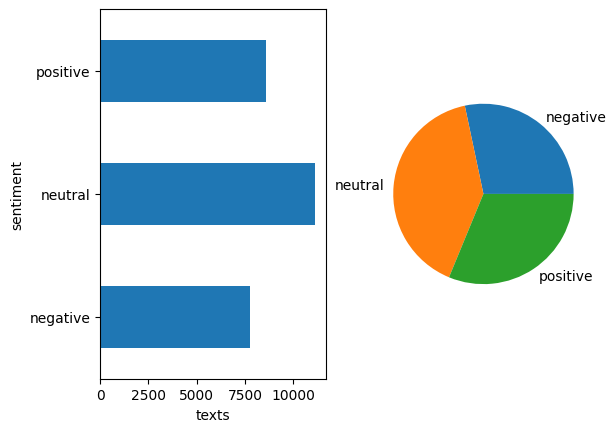

In [7]:
count = train_df["sentiment"].groupby(train_df["sentiment"]).count()
plt.subplot(1, 2, 1)
count.plot(kind='barh', ylabel="sentiment", xlabel="texts")
plt.subplot(1, 2, 2)
count.plot(kind='pie', ylabel="")
plt.show()

# Text Processing

## Text Cleaning

The text needs to be made as consistent as possible, in order for the computer to find patterns more easily. Images, links, mentions, and censored words can't be interpreted easily and are removed. Letters repeated 3 times or more are generally arbitrary amounts used for emphasis, with the specific number not carrying meaning, so they are reduced to 2. Any remaining punctuation and capitalization does not have easily accessible value and is removed.

In [8]:
def clean(text):
    # remove non-word objects
    text = re.sub(r"https?://twitpic\.com/\w+", "image", text)
    text = re.sub(r"https?://\S+", "link", text)
    text = re.sub(r"_\w+", "mention", text)
    text = re.sub(r"\*\*\*\*", "censored", text)
    # reduce repeated letters
    text = re.sub(r"(\w)\1\1+", r"\1\1", text)
    # remove punctation
    text = re.sub(r"\W", " ", text) 
    # lowercase everything
    text = text.lower()
    return text

## Tokenization and Stemming

The cleaned text is split into a list of words, in an attempt to create tokens that each have self-contained meaning. Tokens without significant meaning (stopwords) are ignored. Then, the Porter stemming algorithm is used to remove suffixes and therefore reduce the number of possible tokens for each meaning. This increases consistency in a similar way to the text cleaning.

In [9]:
def tokenize_and_stem(text):
    tokens = text.split()
    with open("stopwords.txt", 'r') as f:
        stopwords = f.read().splitlines()
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens if token not in stopwords]
    return tokens

## Feature Extraction

To be used in a machine learning algorithm, the data needs to be transformed into a set of features. Here we use a binary bag-of-words approach, where each word becomes a feature that is a binary value of whether that word appears in the text or not. Binary values are used rather than counting the occurrences of a token, as each piece of text is very short. The recurrence of a token is uncommon and unlikely to have much meaning.

In [10]:
def extract_features(tokens):
    return dict.fromkeys(tokens, 1)

## Finalization

The above steps are compiled into a text processing function.

In [11]:
def process(text):
    text = clean(text)
    tokens = tokenize_and_stem(text)
    features = extract_features(tokens)
    return features

After applying the processing function to the training dataset, the text data is now much more consistent and simpler to be read by the computer.

In [12]:
train_df["text"] = train_df["text"].map(process)
train_df

,text,sentiment
0,"{'respond': 1, 'go': 1}",neutral
1,"{'soo': 1, 'sad': 1, 'miss': 1, 'san': 1, 'die...",negative
2,"{'boss': 1, 'bulli': 1}",negative
3,"{'interview': 1, 'leav': 1, 'alon': 1}",negative
4,"{'son': 1, 'censor': 1, 'put': 1, 'releas': 1,...",negative
...,...,...
27476,"{'wish': 1, 'could': 1, 'come': 1, 'see': 1, '...",negative
27477,"{'wonder': 1, 'rake': 1, 'client': 1, 'made': ...",negative
27478,"{'yay': 1, 'good': 1, 'enjoy': 1, 'break': 1, ...",positive
27479,"{'worth': 1, 'censor': 1}",positive


# Model Training

First, a vectorizer is trained based on the feature sets in the training data. The trained vectorizer converts the feature sets from the human-readable Python dictionary format to an extremely large binary matrix that includes every feature for every entry. In other words, the data is expanded to also include which tokens are *not* in each text. Since it is a sparse matrix with 0s in most cells, it can still be stored without using much memory.

In [13]:
vectorizer = DictVectorizer()
vectorizer.fit(train_df["text"])
train_x = vectorizer.transform(train_df["text"])
train_x

<27481x18593 sparse matrix of type '<class 'numpy.float64'>'
	with 192746 stored elements in Compressed Sparse Row format>

The sentiments can be left as they are, as there is only one sentiment for each entry.

In [14]:
train_y = train_df["sentiment"].to_numpy()
train_y

array(['neutral', 'negative', 'negative', ..., 'positive', 'positive',
       'neutral'], dtype=object)

The learning algorithm that is used is Bernoulli Naive Bayes. Naive Bayes algorithms are very fast as they take the naive assumption that every feature is conditionally independent from every other. This means that it assumes one token being in the text does not relate to the chance of any other token being in the text. The Bernoulli Naive Bayes algorithm is a particularly effective choice for our purposes, as it specifically utilizes binary features. It finds patterns in not only which tokens are in the text, but also which are not.

In [15]:
classifier = BernoulliNB()
classifier.fit(train_x, train_y)

BernoulliNB()

# Model Testing

The same text processing and vectorizer used for training the model must be re-used in order for the model to understand the data.

In [16]:
test_df["text"] = test_df["text"].map(process)
test_x = vectorizer.transform(test_df["text"])

The model attempts to classify the new data, and then its guesses are compared against the real sentiment values.

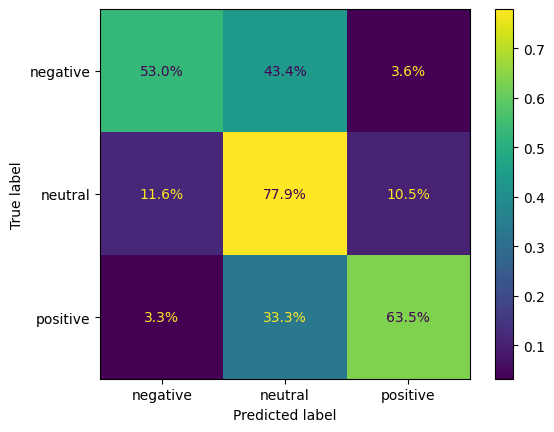

In [17]:
test_y_guess = classifier.predict(test_x)
test_y_truth = test_df["sentiment"].to_numpy()
ConfusionMatrixDisplay.from_predictions(test_y_truth, test_y_guess, normalize='true', values_format='.1%')
plt.show()

The model has a reasonably good accuracy, considering the simplicity of the model, the short length of the text, and the fact that there are 3 categories for the model to choose between for each text.

One shortcoming is that the model seems to frequently err towards neutral, with 43.4% of negative text marked neutral and 33.3% of positive text marked neutral. However, it very successfully avoids marking negative text as positive (3.6%) or positive text as negative (3.3%). This "safe" classification could be useful for some purposes, but other purposes may want to give the neutral label less weight in the model.

Another thing to consider is the imbalance in accuracy between positive and negative. When used for determining the overall sentiment of a large body of text, the model may lean towards positive, as more positive text is classified correctly (63.5%) than negative text (53.0%). Additionally, the model misclassifying 11.6% of neutral text as negative but only 10.5% as positive could add a slight negative lean.

# Usage

## Single text classification

The following code generates an interface for single text classification.

In [18]:
single_text = widgets.Textarea(placeholder="Text to classify")
single_button = widgets.Button(description="Run model")
single_output = widgets.Output()
single_interface = widgets.VBox([single_text, single_button, single_output])

In [19]:
@single_output.capture(clear_output=True, wait=True)
def run_model_single(_):
    processed_text = process(single_text.value)
    x = vectorizer.transform(processed_text)
    print(classifier.predict(x)[0])
single_button.on_click(run_model_single)

Use the model to identify the sentiment in a single new piece of text by typing in the interface below.

In [20]:
display(single_interface)

## Bulk file analysis

The following code generates an interface for bulk file analysis.

In [21]:
bulk_file = widgets.FileUpload(accept=".csv", multiple=False)
bulk_button = widgets.Button(description="Run model")
bulk_output = widgets.Output()
bulk_interface = widgets.VBox([bulk_file, bulk_button, bulk_output])

In [22]:
@bulk_output.capture(clear_output=True, wait=True)
def run_model_bulk(_):
    df = pd.read_csv(io.BytesIO(bulk_file.value[0].content))
    df.dropna()
    df["text"] = df["text"].map(process)
    x = vectorizer.transform(df["text"])
    sentiments = pd.Series(classifier.predict(x))
    count = sentiments.groupby(sentiments).count()
    plt.subplot(1, 2, 1)
    count.plot(kind='barh', ylabel="sentiment", xlabel="texts")
    plt.subplot(1, 2, 2)
    count.plot(kind='pie', ylabel="")
    plt.show()
bulk_button.on_click(run_model_bulk)

Use the model to analyze the overall sentiment of many pieces of text by uploading a CSV file in the interface below. The CSV file should have a column named "text" that contains the pieces of text to analyze.

In [23]:
display(bulk_interface)